### Import library

In [1]:
from pandas import read_csv,concat
from sklearn.model_selection import cross_val_score,RepeatedStratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler,OrdinalEncoder,OneHotEncoder
import numpy as np
from numpy import mean, std
from matplotlib import pyplot
from scipy.sparse import hstack

### Eksplorasi data

In [2]:
# Melihat bentuk dari tabel data

dataset = read_csv('kecepatan-rata-rata-di-41-koridor-jalan-utama-pada-jam-sibuk-januari-2019.csv')
print(dataset.shape)
display(dataset.head(5))

(82, 9)


,waktu,arah,koridor,target_kecepatan,jarak,target_waktu_tempuh,pencapaian_kecepatan_per_koridor,pencapaian_kecepatan,pencapaian_waktu_tempuh
0,pagi,Selatan - Pusat,Lenteng Agung - Ps. Minggu - Supomo - dr. Saha...,20.5,19.62,57.43,22.70,22.98,63.83
1,pagi,Selatan - Pusat,Cilandak KKO - Warung Buncit - Mampang Prapata...,20.5,13.36,39.10,25.43,22.98,37.71
2,pagi,Selatan - Pusat,Pangeran Antasari - Prapanca - Iskandarsyah - ...,20.5,11.13,32.58,27.54,22.98,26.99
3,pagi,Selatan - Pusat,Pondok Labu - Fatmawati - Panglima Polim - Sis...,20.5,16.25,47.56,22.20,22.98,50.82
4,pagi,Selatan - Pusat,Pasar Jumat - Metro Pondok Indah - Iskandar Mu...,20.5,15.87,46.45,25.99,22.98,42.06


### Fungsi untuk mendapatkan data yang sudah digabungkan

In [3]:
# Menggabungkan seluruh data

def get_data():
    dataset = read_csv('kecepatan-rata-rata-di-41-koridor-jalan-utama-pada-jam-sibuk-januari-2019.csv')
    months = ['februari','maret','april','mei','juni','juli','agustus','september','oktober','november','desember']

    for month in months:
        temp = read_csv(f'{month}-2019-data-kecepatan-rata-rata-di-41-koridor-jalan-utama-pada-jam-sibuk.csv')

        # Mengubah nama header yang salah tulis menjadi benar
        if month == 'april':
            temp = temp.rename(columns={"pencapaian_Waktu_tempuh":"pencapaian_waktu_tempuh"})
        dataset = concat([dataset,temp],ignore_index=True)
    return dataset

Setelah menjalankan sekali ditemukan bahwa di data April ada kolom yang penulisan headernya berbeda dari yang lain sehingga menambahkan kolom ke 10. Karena itu nama kolom tersebut harus diubah

### Menghitung akurasi model regresi linear tanpa menggunakan scaling maupun encoder

#### Membersihkan data

In [4]:
dataset = get_data()

# Cek apakah ada kolom single value 
print(dataset.nunique())

duplicates = dataset.duplicated()
print("\nAny Duplicates? ", duplicates.any())
print(dataset[duplicates])
print("number of duplicates: ",duplicates.sum())
dataset.drop_duplicates(inplace=True)
print("\nAny Duplicates? ",dataset.duplicated().any())

print("\nTotal missing value",dataset.isnull().sum().sum())


waktu                                 4
arah                                 10
koridor                              41
target_kecepatan                      6
jarak                                41
target_waktu_tempuh                 237
pencapaian_kecepatan_per_koridor    761
pencapaian_kecepatan                182
pencapaian_waktu_tempuh             846
dtype: int64

Any Duplicates?  True
    waktu arah koridor  target_kecepatan  jarak  target_waktu_tempuh  \
411   NaN  NaN     NaN               NaN    NaN                  NaN   

     pencapaian_kecepatan_per_koridor  pencapaian_kecepatan  \
411                               NaN                   NaN   

     pencapaian_waktu_tempuh  
411                      NaN  
number of duplicates:  1

Any Duplicates?  False

Total missing value 50


Melihat data yang hilang

In [5]:
# Differentiating between rows with complete vs. partial missing data
complete_missing_rows = dataset[dataset.isnull().all(axis=1)]
partial_missing_rows = dataset[dataset.isnull().any(axis=1) & ~dataset.isnull().all(axis=1)]

# Displaying the results
print("\nRows with Complete Missing Data: ",complete_missing_rows.shape)
print(complete_missing_rows)

print("\nRows with Partial Missing Data:",partial_missing_rows.shape)
print(partial_missing_rows)


Rows with Complete Missing Data:  (1, 9)
    waktu arah koridor  target_kecepatan  jarak  target_waktu_tempuh  \
410   NaN  NaN     NaN               NaN    NaN                  NaN   

     pencapaian_kecepatan_per_koridor  pencapaian_kecepatan  \
410                               NaN                   NaN   

     pencapaian_waktu_tempuh  
410                      NaN  

Rows with Partial Missing Data: (41, 9)
    waktu             arah                                            koridor  \
287  sore  Selatan - Pusat  Lenteng Agung - Ps. Minggu - Supomo - dr. Saha...   
288  sore  Selatan - Pusat  Cilandak KKO - Warung Buncit - Mampang Prapata...   
289  sore  Selatan - Pusat  Pangeran Antasari - Prapanca - Iskandarsyah - ...   
290  sore  Selatan - Pusat  Pondok Labu - Fatmawati - Panglima Polim - Sis...   
291  sore  Selatan - Pusat  Pasar Jumat - Metro Pondok Indah - Iskandar Mu...   
292  sore  Selatan - Pusat  Ciledug Raya - Keb Lama - Pakubuwono 6 - Hang ...   
293  sore  Selat

Kita akan delete row yang semua _value_ nya _missing_

In [7]:
dataset_no_missing_row = dataset.dropna(how='all')
print("\nDataFrame setelah drop semua row yang seluruh Valuenya missing:")
print(dataset_no_missing_row.shape)


DataFrame setelah drop semua row yang seluruh Valuenya missing:
(984, 9)


#### Handling data yang hilang

Cek kolom apa saja yang memiliki data hilang

In [8]:
columns_with_missing_values = dataset_no_missing_row.columns[dataset_no_missing_row.isnull().any()]

print("\nKolom yang memiliki missing value: ")
print(columns_with_missing_values)


Kolom yang memiliki missing value: 
Index(['target_kecepatan'], dtype='object')


Karena kolom yang memiliki missing value memiliki variasi yang kecil dan cukup insignifikan kita akan drop saja 

In [9]:
dataset = dataset_no_missing_row.drop(['target_kecepatan'],axis=1)
print("\nTotal missing value",dataset.isnull().sum().sum())



Total missing value 0


### 1. Menghitung akurasi model regresi linear tanpa menggunakan scaling maupun encoder

Function untuk evaluasi model

In [10]:
def evaluate(model,X,y):
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    mae_scores = cross_val_score(model, X, y, scoring=mae_scorer, cv=5)

    print(f"MAE: {-mean(mae_scores)}, Stdev: {std(mae_scores)}")

MAE: 2.052628319222066, Stdev: 0.11669657087454505


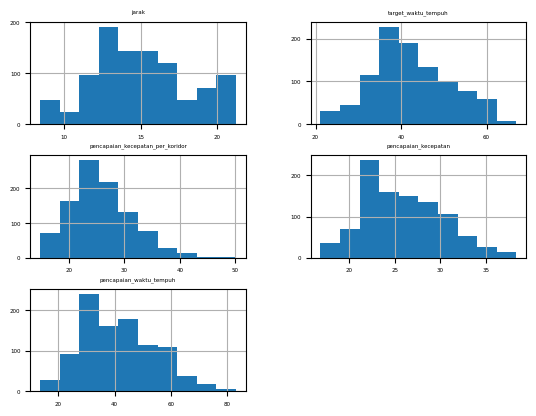

In [11]:
data = dataset.copy() # mengcopy dataset yang sudah di proses  
data = data.select_dtypes(include='number')
y = data['pencapaian_kecepatan']
X = data.drop('pencapaian_kecepatan',axis=1)

model = LinearRegression()

evaluate(model,X,y)

# histograms of the variables
fig = dataset.hist(xlabelsize=4,ylabelsize=4)
[x.title.set_size(4) for x in fig.ravel()]

# show the plot
pyplot.show()

### 2. Membuat histogram untuk tiga cara: (normalisasi, standarisasi, dan robust scaler) untuk fitur numerik

Menggunakan normalisasi MinMaxScaler

MAE: 2.052628319222064, Stdev: 0.11669657087454519


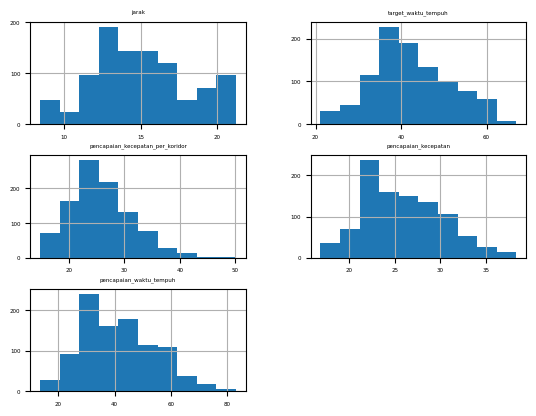

In [12]:
data = dataset.copy() # copy dataset yang sudah dibersihkan
data = data.select_dtypes(include='number') # mengambil hanya kolom yang berisi angka

y = data['pencapaian_kecepatan']
X = data.drop('pencapaian_kecepatan',axis=1)

# define the pipeline
trans = MinMaxScaler()
model = LinearRegression()
X_normalised = trans.fit_transform(X)

evaluate(model,X_normalised,y)

# histograms of the variables
fig = data.hist(xlabelsize=4,ylabelsize=4)
[x.title.set_size(4) for x in fig.ravel()]

# show the plot
pyplot.show()

Menggunakan standarisasi

MAE: 2.052628319222066, Stdev: 0.11669657087454535


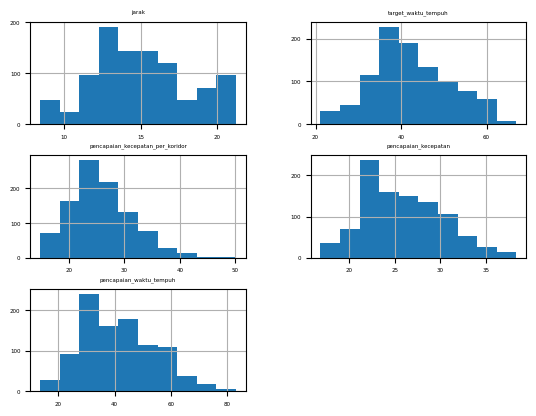

In [13]:
data = dataset.copy() # copy dataset yang sudah dibersihkan
data = data.select_dtypes(include='number') # mengambil hanya kolom yang berisi angka

y = data['pencapaian_kecepatan']
X = data.drop('pencapaian_kecepatan',axis=1)

# define the pipeline
trans = StandardScaler()
model = LinearRegression()
X_standard = trans.fit_transform(X)

evaluate(model,X_standard,y)

# histograms of the variables
fig = data.hist(xlabelsize=4,ylabelsize=4)
[x.title.set_size(4) for x in fig.ravel()]

# show the plot
pyplot.show()

Menggunakan robust scaler

MAE: 2.0526283192220656, Stdev: 0.11669657087454516


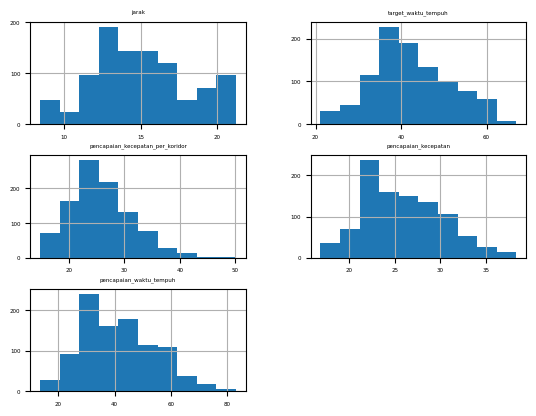

In [14]:
data = dataset.copy() # copy dataset yang sudah dibersihkan
data = data.select_dtypes(include='number') # mengambil hanya kolom yang berisi angka

y = data['pencapaian_kecepatan']
X = data.drop('pencapaian_kecepatan',axis=1)

# define the pipeline
trans = RobustScaler()
model = LinearRegression()
X_robust = trans.fit_transform(X)

evaluate(model,X_robust,y)


# histograms of the variables
fig = data.hist(xlabelsize=4,ylabelsize=4)
[x.title.set_size(4) for x in fig.ravel()]

# show the plot
pyplot.show()

### Menggunakan onehot encoder dan ordinal encoder terhadap dataset untuk fitur kategorial.

Dengan onehot encoder

In [15]:
data = dataset.copy() # mengcopy dataset yang sudah di proses  
y = data['pencapaian_kecepatan']
X = data.select_dtypes('object') # untuk mendapatkan yang kategorial saja

model = LinearRegression()
encoder = OneHotEncoder(sparse_output=True)
X_onehot = encoder.fit_transform(X)

display(X_onehot.shape)

evaluate(model,X_onehot,y)

(984, 55)

MAE: 3.1203503788500897, Stdev: 0.46155273496905735


Dengan ordinal encoder

In [16]:
data = dataset.copy() # mengcopy dataset yang sudah di proses  
y = data['pencapaian_kecepatan']
X = data.select_dtypes('object') # untuk mendapatkan yang kategorial saja

model = LinearRegression()
encoder = OrdinalEncoder()
X_ordinal = encoder.fit_transform(X)

display(X_ordinal.shape)

evaluate(model,X_ordinal,y)

(984, 3)

MAE: 3.6464982244202573, Stdev: 0.6473613865715019


### 4. Menggunakan kombinasi transformasi data untuk semua fitur.

OneHot + MinMaxScaler

In [17]:
data = dataset.copy() # mengcopy dataset yang sudah di proses  
y = data['pencapaian_kecepatan']
X = hstack([X_onehot,X_normalised]) # Gunakan hstack untuk X_onehot karena bentuknya adalah sparse matrix
model = LinearRegression()

evaluate(model,X,y)

MAE: 1.332099329328249, Stdev: 0.15545039734955335


OneHot + StandardScaler

In [18]:
data = dataset.copy() # mengcopy dataset yang sudah di proses  
y = data['pencapaian_kecepatan']
X = hstack([X_onehot,X_standard])
model = LinearRegression()

evaluate(model,X,y)

MAE: 1.331872114340516, Stdev: 0.15524952125984873


OneHot + RobustScaler

In [19]:
data = dataset.copy() # mengcopy dataset yang sudah di proses  
y = data['pencapaian_kecepatan']
X = hstack([X_onehot,X_robust])
model = LinearRegression()

evaluate(model,X,y)

MAE: 1.3318805298335026, Stdev: 0.15525751443085736


Ordinal + MinMax


In [20]:
data = dataset.copy() # mengcopy dataset yang sudah di proses  
y = data['pencapaian_kecepatan']
X = np.concatenate((X_ordinal,X_normalised),axis=1)

model = LinearRegression()

evaluate(model,X,y)

MAE: 2.165160002238872, Stdev: 0.35764715716872114


Ordinal + Standarisasi

In [21]:
data = dataset.copy() # mengcopy dataset yang sudah di proses  
y = data['pencapaian_kecepatan']
X = np.concatenate((X_ordinal,X_standard),axis=1)

model = LinearRegression()

evaluate(model,X,y)

MAE: 2.1651600022388764, Stdev: 0.35764715716872475


Ordinal + RobustScaler

In [22]:
data = dataset.copy() # mengcopy dataset yang sudah di proses  
y = data['pencapaian_kecepatan']
X = np.concatenate((X_ordinal,X_robust),axis=1)

model = LinearRegression()

evaluate(model,X,y)

MAE: 2.165160002238876, Stdev: 0.3576471571687249


### 5. Perbandingan akurasi setiap skenario (dengan metrik MAE)

1. Original data MAE: 2.052 (0.116)
2. MinMaxScaler MAE: 2.052 (0.116)
3. StandardScaler MAE: 2.052 (0.116)
4. RobustScaler MAE: 2.052 (0.116)
5. OrdinalEncoder MAE: 3.646 (0.647)
6. OneHotEncoder MAE: 3.120 (0.461)
7. OneHotEncoder + MinMaxScaler MAE: 1.332 (0.155)
8. OrdinalEncoder + MinMaxScaler MAE: 2.165 (0.358)
9. OneHotEncoder + StandardScaler MAE: 1.332 (0.155)
10. OrdinalEncoder + StandardScaler MAE: 2.165 (0.358)
11. OneHotEncoder + RobustScaler MAE: 1.332 (0.155)
12. OrdinalEncoder + RobustScaler MAE: 2.165 (0.358)

### Kesimpulan

Dari hasil perbanding diatas dapat dilihat metode yang memberikan MAE paling tinggi adalah dengan Ordinal Encoder saja dan yang paling rendah adalah kombinasi OneHot Encoder dengan scaler yang manapun. Walaupun begitu ini tidak memastikan bahwa metode Ordinal Encoder dengan scaler apa saja merupakan metode pembersihan data yang paling optimal untuk dataset ini melainkan yang memberikan MAE paling rendah.

Bisa dilihat dari histogram bahwa distribusi antara data original, normalisasi, standarisasi, dan robust scaler tidak menunjukkan perbedaan yang signifikan dan juga memberikan nilai MAE dan stdev yang sama. Selain itu metode OneHot encoder dengan scaler apapun dan juga OrdinalEncoder dengan scaler apapun masing-masing menjukkan nilai sama untuk setiap kombinasi scaler 